<a href="https://colab.research.google.com/github/shshojaei/research-of-super-resolution/blob/main/EDSR_my_ssim_luminance_psnr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

source: https://keras.io/examples/vision/edsr/



In [ ]:
import os, shutil
from google.colab import drive
drive.mount('/content/drive')
!ls 'drive/MyDrive/Colab Notebooks/EDSR'

Mounted at /content/drive
my_mae	my_mse	my_ssim_luminance_main	my_ssim_luminance_psnr


## **Imports**

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.vgg19 import VGG19
from keras.models import Sequential

AUTOTUNE = tf.data.AUTOTUNE #for data augmentation

## **prepare dataset**

In [ ]:
# Download DIV2K from TF Datasets
# Using bicubic 4x degradation type
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()
    

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteOEUZPH/div2k-train.tfrecord


  0%|          | 0/800 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteOEUZPH/div2k-validation.tfrecord


  0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


## **image pre-processing**


*   batch size



In [ ]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=96, scale=4):
    """Crop images.

    low resolution images: 24x24
    hight resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped

In [ ]:
def dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=4),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

In [ ]:
#visualize a few sample images

lowres, highres = next(iter(train_ds))

# Hight Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")

## **architecture** (method)


*   scale



In [ ]:
# Residual Block
def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x

In [ ]:
# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x

In [ ]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

In [ ]:
model.summary()

Model: "edsr_model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_4 (Rescaling)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d_74 (Conv2D)             (None, None, None,   1792        ['rescaling_4[0][0]']            
                                64)                                                    

## **Training**


*   Optimizer
*   learning rate
*   loss function
*   epochs



In [ ]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optimizer_ = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)

In [ ]:
import keras.backend as K

def my_mae(y_true, y_pred):
  
  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)

  #convert Tensorflow tensor to numpy
  y_true = K.cast( y_true, 'float32')
  y_pred = K.cast( y_pred, 'float32')

  return K.mean(K.abs(y_pred - y_true), axis=-1)


In [ ]:
import keras.backend as K

def my_mse(y_true, y_pred):
  
  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)

  #convert Tensorflow tensor to numpy
  y_true = K.cast( y_true, 'float32')
  y_pred = K.cast( y_pred, 'float32')

  return K.mean(K.square(y_pred - y_true), axis=-1)

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.1 MB/s 


In [ ]:
import keras.backend as K
import tensorflow_addons as tfa

def my_ssim_luminance_psnr(y_true, y_pred):

  #source: https://www.tensorflow.org/addons/api_docs/python/tfa/image/gaussian_filter2d
  y_true = tfa.image.gaussian_filter2d(y_true, filter_shape=(11,11), sigma=1.5) #input and output is a Tensor
  y_pred = tfa.image.gaussian_filter2d(y_pred, filter_shape=(11,11), sigma=1.5)

  y_true = K.flatten(y_true)
  y_pred = K.flatten(y_pred)

  #convert Tensorflow tensor to numpy
  y_true = K.cast( y_true, 'float64')
  y_pred = K.cast( y_pred, 'float64')

  return K.mean(K.square(y_pred - y_true), axis=-1)

In [ ]:
def PSNR(super_resolution, high_resolution):
  #Compute the peak signal-to-noise ratio, measures quality of image.
  # Max value of pixel is 255
  psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
  return psnr_value

In [ ]:
#source: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

checkpoint_filepath = 'drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_psnr/checkpoint'
STEPS_PER_EPOCH = 200

#Create a callback that saves the model's weights every 10 epochs 
#source: https://stackoverflow.com/questions/59069058/save-model-every-10-epochs-tensorflow-keras-v2

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    verbose=1,
    monitor='val_loss',
    mode='min',
    save_freq= int(10 * STEPS_PER_EPOCH)
)

In [ ]:
model.compile(optimizer=optimizer_ , loss=my_ssim_luminance_psnr , metrics=[PSNR])

# Training for more epochs will improve results
history_my_ssim_luminance_psnr = model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds, callbacks=[model_checkpoint_callback])

Epoch 1/100
200/200 [==============================] - 10s 40ms/step - loss: 877.0810 - PSNR: 5.0026 - val_loss: 168.7759 - val_PSNR: 6.2236
Epoch 2/100
200/200 [==============================] - 8s 38ms/step - loss: 119.3607 - PSNR: 6.8545 - val_loss: 107.6853 - val_PSNR: 6.0123
Epoch 3/100
200/200 [==============================] - 8s 38ms/step - loss: 94.4191 - PSNR: 7.2696 - val_loss: 74.1873 - val_PSNR: 6.8400
Epoch 4/100
200/200 [==============================] - 8s 38ms/step - loss: 71.4426 - PSNR: 8.0871 - val_loss: 57.5477 - val_PSNR: 8.3310
Epoch 5/100
200/200 [==============================] - 9s 43ms/step - loss: 55.1805 - PSNR: 8.1563 - val_loss: 65.1040 - val_PSNR: 9.7436
Epoch 6/100
200/200 [==============================] - 8s 40ms/step - loss: 51.4798 - PSNR: 9.0496 - val_loss: 71.1388 - val_PSNR: 8.9711
Epoch 7/100
200/200 [==============================] - 7s 37ms/step - loss: 56.4031 - PSNR: 9.6191 - val_loss: 45.7999 - val_PSNR: 7.9107
Epoch 8/100
200/200 [========

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_psnr/checkpoint/assets


200/200 [==============================] - 13s 63ms/step - loss: 42.1496 - PSNR: 10.6005 - val_loss: 34.4089 - val_PSNR: 10.9836
Epoch 11/100
200/200 [==============================] - 8s 38ms/step - loss: 36.5663 - PSNR: 10.6004 - val_loss: 40.2265 - val_PSNR: 11.1037
Epoch 12/100
200/200 [==============================] - 8s 38ms/step - loss: 34.4011 - PSNR: 10.6088 - val_loss: 55.2964 - val_PSNR: 12.0760
Epoch 13/100
200/200 [==============================] - 8s 40ms/step - loss: 35.3539 - PSNR: 11.5124 - val_loss: 27.5900 - val_PSNR: 12.7641
Epoch 14/100
200/200 [==============================] - 8s 38ms/step - loss: 30.7103 - PSNR: 11.3354 - val_loss: 28.8772 - val_PSNR: 11.4265
Epoch 15/100
200/200 [==============================] - 7s 37ms/step - loss: 39.4595 - PSNR: 11.7904 - val_loss: 27.5962 - val_PSNR: 9.0943
Epoch 16/100
200/200 [==============================] - 7s 37ms/step - loss: 30.7020 - PSNR: 11.9995 - val_loss: 28.5422 - val_PSNR: 11.9996
Epoch 17/100
200/200 [====

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_psnr/checkpoint/assets


200/200 [==============================] - 12s 62ms/step - loss: 34.4472 - PSNR: 13.5088 - val_loss: 27.4942 - val_PSNR: 12.4386
Epoch 21/100
200/200 [==============================] - 7s 37ms/step - loss: 29.6597 - PSNR: 13.2984 - val_loss: 26.4457 - val_PSNR: 13.8628
Epoch 22/100
200/200 [==============================] - 8s 38ms/step - loss: 24.4268 - PSNR: 14.0214 - val_loss: 33.8091 - val_PSNR: 13.0891
Epoch 23/100
200/200 [==============================] - 8s 38ms/step - loss: 22.9668 - PSNR: 13.8416 - val_loss: 23.8420 - val_PSNR: 11.6855
Epoch 24/100
200/200 [==============================] - 8s 38ms/step - loss: 29.3837 - PSNR: 14.4446 - val_loss: 20.9915 - val_PSNR: 13.5769
Epoch 25/100
200/200 [==============================] - 8s 38ms/step - loss: 22.2275 - PSNR: 14.2208 - val_loss: 28.9559 - val_PSNR: 13.5244
Epoch 26/100
200/200 [==============================] - 7s 37ms/step - loss: 18.7825 - PSNR: 14.7246 - val_loss: 18.2858 - val_PSNR: 14.0372
Epoch 27/100
200/200 [===

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_psnr/checkpoint/assets


200/200 [==============================] - 13s 63ms/step - loss: 17.3179 - PSNR: 13.9262 - val_loss: 17.8470 - val_PSNR: 12.6487
Epoch 31/100
200/200 [==============================] - 8s 39ms/step - loss: 20.9118 - PSNR: 14.3011 - val_loss: 52.3881 - val_PSNR: 11.8858
Epoch 32/100
200/200 [==============================] - 7s 37ms/step - loss: 20.0538 - PSNR: 14.3929 - val_loss: 18.9546 - val_PSNR: 13.0340
Epoch 33/100
200/200 [==============================] - 7s 37ms/step - loss: 17.9123 - PSNR: 14.4416 - val_loss: 14.2832 - val_PSNR: 15.5393
Epoch 34/100
200/200 [==============================] - 7s 37ms/step - loss: 16.3830 - PSNR: 14.6958 - val_loss: 16.9136 - val_PSNR: 14.2388
Epoch 35/100
200/200 [==============================] - 8s 38ms/step - loss: 18.3266 - PSNR: 14.3704 - val_loss: 13.5542 - val_PSNR: 12.7980
Epoch 36/100
200/200 [==============================] - 7s 37ms/step - loss: 17.6875 - PSNR: 14.4622 - val_loss: 20.8625 - val_PSNR: 14.1130
Epoch 37/100
200/200 [===

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_psnr/checkpoint/assets


200/200 [==============================] - 12s 63ms/step - loss: 15.7396 - PSNR: 14.8766 - val_loss: 14.1973 - val_PSNR: 13.5848
Epoch 41/100
200/200 [==============================] - 7s 37ms/step - loss: 16.0582 - PSNR: 14.9660 - val_loss: 17.4077 - val_PSNR: 14.4306
Epoch 42/100
200/200 [==============================] - 7s 37ms/step - loss: 15.6710 - PSNR: 15.1961 - val_loss: 17.8797 - val_PSNR: 12.4351
Epoch 43/100
200/200 [==============================] - 7s 37ms/step - loss: 17.9516 - PSNR: 15.0439 - val_loss: 17.0039 - val_PSNR: 15.6773
Epoch 44/100
200/200 [==============================] - 8s 38ms/step - loss: 18.1308 - PSNR: 15.2867 - val_loss: 14.5551 - val_PSNR: 14.3008
Epoch 45/100
200/200 [==============================] - 8s 38ms/step - loss: 15.9820 - PSNR: 15.2555 - val_loss: 13.9510 - val_PSNR: 13.8876
Epoch 46/100
200/200 [==============================] - 7s 37ms/step - loss: 16.1052 - PSNR: 15.4088 - val_loss: 15.8241 - val_PSNR: 14.3410
Epoch 47/100
200/200 [===

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_psnr/checkpoint/assets


200/200 [==============================] - 12s 63ms/step - loss: 16.0604 - PSNR: 15.6970 - val_loss: 13.3925 - val_PSNR: 16.3022
Epoch 51/100
200/200 [==============================] - 7s 37ms/step - loss: 15.1708 - PSNR: 15.4614 - val_loss: 14.0620 - val_PSNR: 16.1255
Epoch 52/100
200/200 [==============================] - 8s 38ms/step - loss: 14.8160 - PSNR: 15.8362 - val_loss: 18.7104 - val_PSNR: 14.5230
Epoch 53/100
200/200 [==============================] - 8s 38ms/step - loss: 15.0999 - PSNR: 15.9227 - val_loss: 17.1977 - val_PSNR: 15.8587
Epoch 54/100
200/200 [==============================] - 8s 38ms/step - loss: 18.1734 - PSNR: 16.2678 - val_loss: 15.6326 - val_PSNR: 15.8031
Epoch 55/100
200/200 [==============================] - 8s 38ms/step - loss: 13.9265 - PSNR: 16.0452 - val_loss: 12.9531 - val_PSNR: 15.4824
Epoch 56/100
200/200 [==============================] - 7s 37ms/step - loss: 12.9194 - PSNR: 16.1435 - val_loss: 12.4575 - val_PSNR: 16.1194
Epoch 57/100
200/200 [===

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_psnr/checkpoint/assets


200/200 [==============================] - 12s 60ms/step - loss: 13.8882 - PSNR: 16.5663 - val_loss: 13.9362 - val_PSNR: 15.3102
Epoch 61/100
200/200 [==============================] - 8s 38ms/step - loss: 13.8714 - PSNR: 16.4677 - val_loss: 24.3883 - val_PSNR: 15.2514
Epoch 62/100
200/200 [==============================] - 7s 37ms/step - loss: 14.6725 - PSNR: 16.6872 - val_loss: 13.8368 - val_PSNR: 16.2405
Epoch 63/100
200/200 [==============================] - 8s 38ms/step - loss: 14.1911 - PSNR: 16.3760 - val_loss: 14.3976 - val_PSNR: 16.1895
Epoch 64/100
200/200 [==============================] - 8s 38ms/step - loss: 13.2567 - PSNR: 16.6449 - val_loss: 16.7129 - val_PSNR: 15.6602
Epoch 65/100
200/200 [==============================] - 8s 38ms/step - loss: 13.3678 - PSNR: 16.8946 - val_loss: 11.6602 - val_PSNR: 15.8298
Epoch 66/100
200/200 [==============================] - 8s 38ms/step - loss: 14.4189 - PSNR: 17.4476 - val_loss: 11.8788 - val_PSNR: 17.8085
Epoch 67/100
200/200 [===

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_psnr/checkpoint/assets


200/200 [==============================] - 13s 64ms/step - loss: 12.2840 - PSNR: 17.1654 - val_loss: 15.7792 - val_PSNR: 17.5562
Epoch 71/100
200/200 [==============================] - 8s 38ms/step - loss: 17.0682 - PSNR: 17.8099 - val_loss: 12.8525 - val_PSNR: 16.7754
Epoch 72/100
200/200 [==============================] - 8s 38ms/step - loss: 12.0815 - PSNR: 17.4161 - val_loss: 12.3701 - val_PSNR: 18.0367
Epoch 73/100
200/200 [==============================] - 8s 38ms/step - loss: 12.0983 - PSNR: 17.3512 - val_loss: 11.9797 - val_PSNR: 18.1136
Epoch 74/100
200/200 [==============================] - 8s 39ms/step - loss: 12.2600 - PSNR: 17.9502 - val_loss: 12.1440 - val_PSNR: 16.8472
Epoch 75/100
200/200 [==============================] - 8s 38ms/step - loss: 13.0649 - PSNR: 17.7854 - val_loss: 10.3639 - val_PSNR: 16.9337
Epoch 76/100
200/200 [==============================] - 8s 38ms/step - loss: 12.5585 - PSNR: 17.8035 - val_loss: 12.2790 - val_PSNR: 14.8755
Epoch 77/100
200/200 [===

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_psnr/checkpoint/assets


200/200 [==============================] - 14s 68ms/step - loss: 12.1568 - PSNR: 17.4922 - val_loss: 13.5509 - val_PSNR: 14.8161
Epoch 81/100
200/200 [==============================] - 8s 38ms/step - loss: 14.2860 - PSNR: 18.4246 - val_loss: 19.6755 - val_PSNR: 18.1470
Epoch 82/100
200/200 [==============================] - 8s 38ms/step - loss: 13.1892 - PSNR: 18.8463 - val_loss: 10.0243 - val_PSNR: 17.1164
Epoch 83/100
200/200 [==============================] - 8s 38ms/step - loss: 11.8520 - PSNR: 18.0173 - val_loss: 13.7162 - val_PSNR: 18.7455
Epoch 84/100
200/200 [==============================] - 8s 39ms/step - loss: 11.2617 - PSNR: 18.4065 - val_loss: 12.8089 - val_PSNR: 18.6358
Epoch 85/100
200/200 [==============================] - 8s 39ms/step - loss: 11.5579 - PSNR: 18.1356 - val_loss: 12.0473 - val_PSNR: 16.8516
Epoch 86/100
200/200 [==============================] - 8s 38ms/step - loss: 11.3661 - PSNR: 18.3939 - val_loss: 11.3800 - val_PSNR: 17.8634
Epoch 87/100
200/200 [===

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_psnr/checkpoint/assets


200/200 [==============================] - 13s 66ms/step - loss: 11.6824 - PSNR: 18.1790 - val_loss: 11.0167 - val_PSNR: 16.6745
Epoch 91/100
200/200 [==============================] - 8s 38ms/step - loss: 11.7778 - PSNR: 18.2995 - val_loss: 12.4484 - val_PSNR: 16.6283
Epoch 92/100
200/200 [==============================] - 8s 38ms/step - loss: 11.5123 - PSNR: 18.4228 - val_loss: 13.3847 - val_PSNR: 19.6676
Epoch 93/100
200/200 [==============================] - 8s 39ms/step - loss: 13.2317 - PSNR: 18.4106 - val_loss: 12.9759 - val_PSNR: 17.5169
Epoch 94/100
200/200 [==============================] - 8s 39ms/step - loss: 11.0239 - PSNR: 19.0156 - val_loss: 8.8482 - val_PSNR: 19.9751
Epoch 95/100
200/200 [==============================] - 8s 38ms/step - loss: 12.1382 - PSNR: 18.6849 - val_loss: 11.4057 - val_PSNR: 18.0546
Epoch 96/100
200/200 [==============================] - 8s 38ms/step - loss: 11.5539 - PSNR: 18.9374 - val_loss: 11.3934 - val_PSNR: 19.2235
Epoch 97/100
200/200 [====

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_psnr/checkpoint/assets


200/200 [==============================] - 13s 66ms/step - loss: 11.5972 - PSNR: 18.9676 - val_loss: 10.9207 - val_PSNR: 19.2492


In [ ]:
#to continue training from last epoch that saved ?????
#model.load_weights(checkpoint_filepath)

In [ ]:
model.save('drive/MyDrive/Colab Notebooks/EDSR/my_ssim_luminance_psnr/model_my_ssim_luminance_psnr.hdf5')

In [ ]:
#model = tf.keras.models.load_model('drive/My Drive/Colab Notebooks/EDSR/model_my_mae.hdf5')

## **plots**

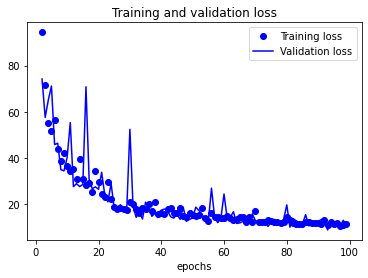

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history_my_ssim_luminance_psnr.history['loss']
PSNR = history_my_ssim_luminance_psnr.history['PSNR']
val_loss = history_my_ssim_luminance_psnr.history['val_loss']
val_PSNR = history_my_ssim_luminance_psnr.history['val_PSNR']

epochs = range(2,len(loss))

plt.plot(epochs, loss[2:], 'bo', label='Training loss')
plt.plot(epochs, val_loss[2:], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.legend()

plt.figure()

plt.show()